In [1]:
import os
import tarfile
import shutil
import tempfile
import time
import pickle
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

#import torch
#import torch.nn.parallel
#import torch.distributed as dist

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: d:\Alexander\1_Doctorado\Software\No_supervisado\MS-Former\.venv\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cpu
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about install

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import os
import numpy as np
import torch.nn.init
import random
import glob
import tqdm.notebook
from einops.layers.torch import Rearrange
from matplotlib import pyplot as plt
import glob
import cv2
import nibabel as nib

from utils import dice_metric, xor_metric, hm_metric, create_mask
from MSFormer_utils import *

In [3]:
use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='MS-Former:Multi-scale Self-guided Transformer for Medical Image Segmentation')
parser.add_argument('--nChannel', metavar='N', default=100, type=int, 
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=50, type=int, 
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, 
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.1, type=float, 
                    help='learning rate')
parser.add_argument('--input_path', metavar='input', default='./input', 
                    help='input image folder path', required=False)
parser.add_argument('--save_output', metavar='save output', default=True, 
                    help='whether to save output ot not')
parser.add_argument('--output_path', metavar='output path', default='./results/', 
                    help='output folder path')
args = parser.parse_args(args=[])

In [4]:
SAVE_PATH = args.output_path
os.makedirs(SAVE_PATH, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data simple (.bmp, .jpg ...)

In [19]:
img_path = args.input_path + '/image/*'
lbl_path = args.input_path + '/GT/*'

img_data = sorted(glob.glob(img_path))
lbl_data = sorted(glob.glob(lbl_path))

In [20]:
len(img_data), len(lbl_data)

(2, 3)

# Modelo de segmentacion SegResNet

In [5]:
val_interval = 1

#VAL_AMP = True
VAL_AMP= False
    
# Select device gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
)

model.to(device)


post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input, model):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
   

Device: cpu


d:\Alexander\1_Doctorado\Software\No_supervisado\MS-Former\.venv\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [6]:
artifact_dir='Weights'

checkpoint = torch.load(os.path.join(artifact_dir, 'best_metric_model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

# Leer imagen y pre-procesarla

In [11]:
# Define the folder path
folder_path = './input/MRI/'

# Find all NIfTI files in the folder
nii_files = glob.glob(folder_path + '*.nii')

# Sort the list of NIfTI files by their file name
nii_files = sorted(nii_files, key=lambda x: (
    1 if "flair.nii" in x else 2 if "t1.nii" in x else 3 if "t1Gd.nii" in x else 4 if "t2.nii" in x else 5
))

# Create an empty list to store the volumes
volumes = []

# Iterate over the NIfTI files and load the volumes
for file_path in nii_files:
    img = nib.load(file_path)
    data = img.get_fdata()
    volumes.append(data)

# Convert the list of volumes into a NumPy array
volumes_np = np.array(volumes)

# Convert the NumPy array to a PyTorch tensor
val_ds= torch.tensor(volumes_np, dtype=torch.float32)

print(val_ds.size())  # Debería imprimir torch.Size([4, 240, 240, 155])

torch.Size([4, 240, 240, 155])


In [12]:
# Convierte el tensor resultante en un diccionario MONAI
data_dict = {"image": val_ds}

# Define las transformaciones solo para "image"
transformaciones = Compose([
    #EnsureChannelFirstd(keys=["image"]),
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# Aplica las transformaciones solo al diccionario "image"
resultado_transformado = transformaciones(data_dict)

# El resultado transformado contendrá la imagen transformada en data_dict["image"]
imagen_transformada = resultado_transformado["image"]

## Hacer inferencia

In [13]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    
    n_case=32
    val_input = imagen_transformada.unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input, model)
    val_output = post_trans(val_output[0])

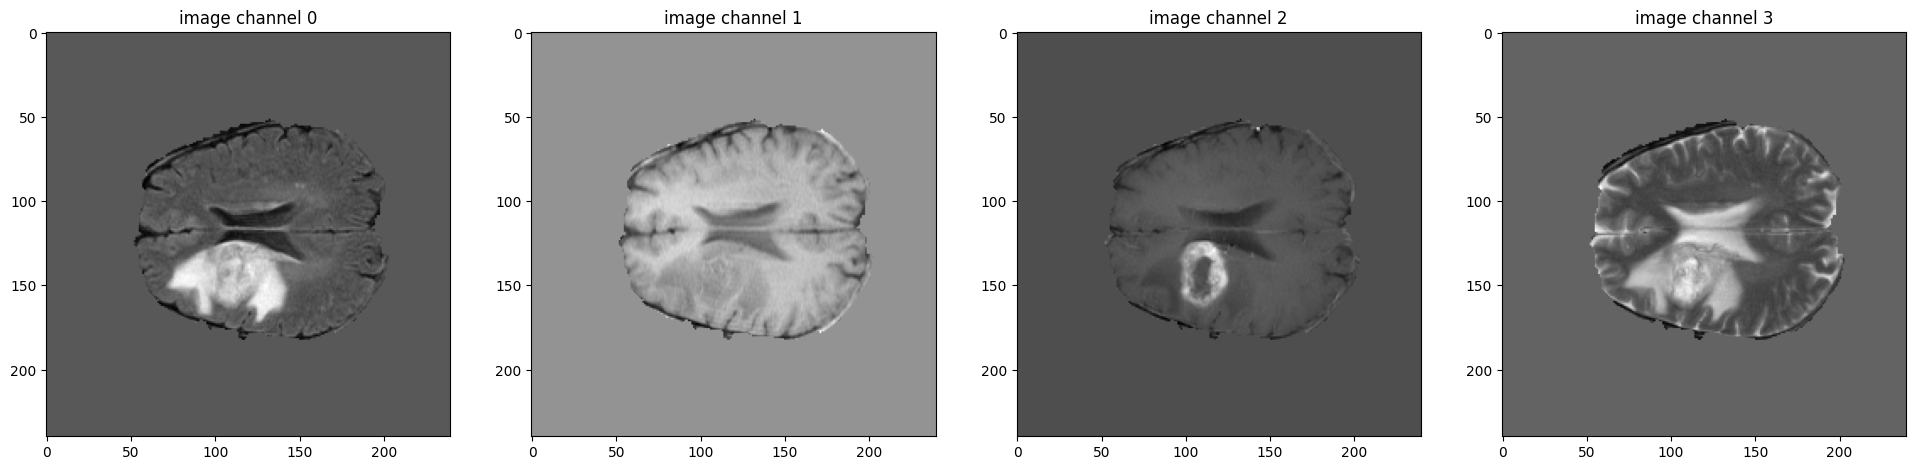

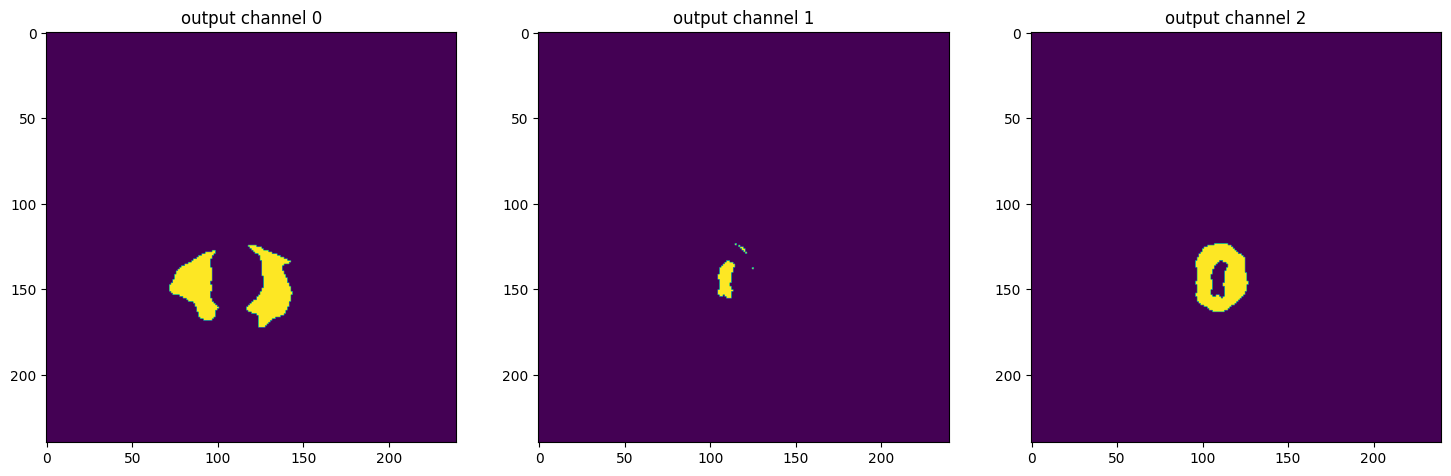

In [14]:
sl=91
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(imagen_transformada[i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()


# visualize the 3 channels model output corresponding to this image
plt.figure("output", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"output channel {i}")
    plt.imshow(val_output[i, :, :, sl].detach().cpu())
plt.show()

In [15]:
# Aplica la máscara binaria a las imágenes
imagenes_segmentadas = imagen_transformada *val_output[0, :, :, :].unsqueeze(0)  # Añade una dimensión de lote (batch)

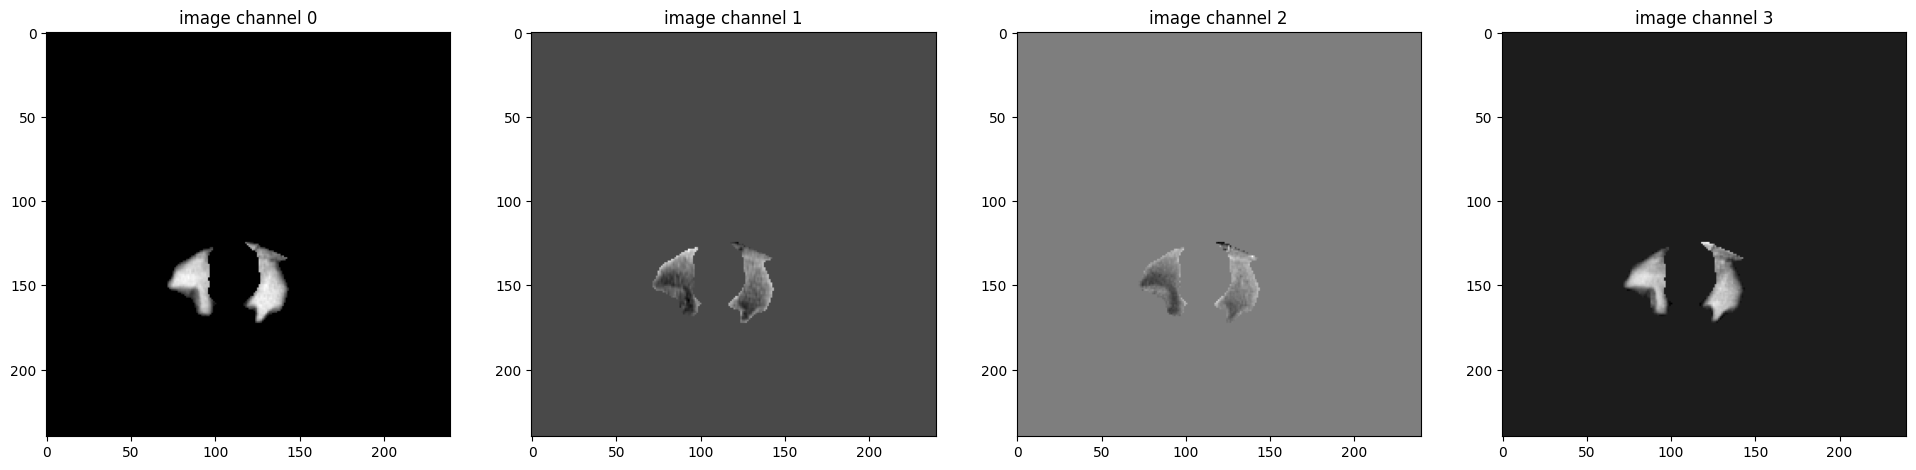

In [16]:
sl=91
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(imagenes_segmentadas[i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()

## Load Images .nii

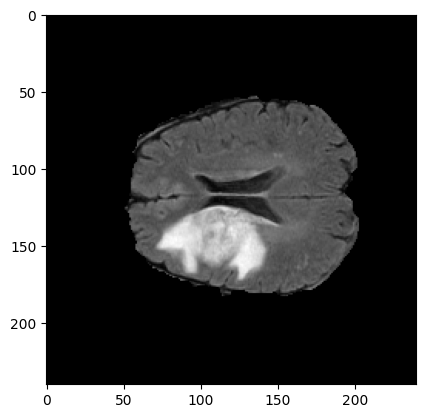

Dimensiones de la imagen original: 4


In [26]:
# Define the folder path
folder_path = './input/MRI/'

# Find all NIfTI files in the folder
nii_files = glob.glob(folder_path + '*.nii')

# Iterate over the NIfTI files and load them
mimg=[]
for file_path in nii_files:
    img = nib.load(file_path)
    data = img.get_fdata()

    # Get the slice you want to visualize
    slice_num = 90
    slice=(data[:, :, slice_num])
    mimg.append(slice)

    # Visualize the slice using Matplotlib
plt.imshow(mimg[0], cmap='gray')
plt.show()
print("Dimensiones de la imagen original:", len(mimg))

In [27]:
# Convierte la lista de slices en un tensor de torch
mimg_tensor = torch.from_numpy(np.stack(mimg, axis=0).astype('float32'))
mimg_tensor = mimg_tensor.unsqueeze(0)


# Verifica el tamaño del tensor resultante
print(mimg_tensor.size())

torch.Size([1, 4, 240, 240])


In [23]:
for img_num, img_file in enumerate(img_data):

    ######################################### Read Data #########################################
    im = cv2.imread(img_file)


    data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32')/255.]))
    print(data.size())

torch.Size([1, 3, 266, 319])
torch.Size([1, 3, 257, 257])


# Model

In [28]:
class MSFormer(nn.Module):
    def __init__(self, input_dim, embed_size=100, img_size=257, large_nlayers=[1], small_nlayers=[1]):
        super(MSFormer, self).__init__()
        
        self.dim = embed_size
        self.img_size = img_size
        self.dim_scale = 2
        self.img_size_l = self.img_size //self.dim_scale + 1
        self.patch_size = 32
        self.large_nlayers = large_nlayers[0]
        self.small_nlayers = small_nlayers[0]
        
        # Patch Embedding
        # Patch size = 1 
        self.patch_embed_s = OverlapPatchEmbeddings(img_size=self.img_size, patch_size=3, stride=1, padding=1,
                                                    in_ch=input_dim, dim=self.dim)
        # Patch size = 2
        self.patch_embed_l = OverlapPatchEmbeddings(img_size=self.img_size, patch_size=3, stride=2, padding=1,
                                                    in_ch=input_dim, dim=self.dim) 
        
        # Efficient Transformer Blocks for the small branch
        self.block_s = nn.ModuleList([ 
            EfficientTransformerBlock(self.dim, self.dim, self.dim, 1, 'mix_skip')
        for _ in range(small_nlayers[0])])
        
        # Efficient Transformer Blocks for the large branch
        self.block_l = nn.ModuleList([ 
            EfficientTransformerBlock(self.dim, self.dim, self.dim, 1, 'mix_skip')
        for _ in range(large_nlayers[0])])
            
        # Batch Normalization layer for the small branch: applied after each Transformer block   
        self.bn2_s = nn.ModuleList()
        for i in range(small_nlayers[0]):
            self.bn2_s.append(nn.BatchNorm2d(self.dim))     
       
        # Batch Normalization layer for the large branch: applied after each Transformer block   
        self.bn2_l = nn.ModuleList()
        for i in range(large_nlayers[0]):
            self.bn2_l.append(nn.BatchNorm2d(self.dim))            
        
        # Upsampling layer
        self.linear_up = nn.Linear(self.dim, 4 * self.dim, bias=False)
        
        # Final prediction layer
        self.linear_down = nn.Linear(2 * self.dim, args.nChannel, bias=False)
        
        # Self-attention layer for intra-scale module
        self.softmax = torch.nn.Softmax(dim=-1)
        patch_dim = self.dim  * self.patch_size * self.patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(patch_dim, self.dim))
        
        self.bn3 = nn.BatchNorm2d(self.dim)


    def forward(self, x):
        # Patch embedding for the small branch
        x_s, h_s, w_s = self.patch_embed_s(x)
        x_s = Rearrange('b (h w) d -> b d h w', h=h_s, w=w_s)(x_s)
        
        # Patch embedding for the large branch
        x_l, h_l, w_l = self.patch_embed_l(x)
        x_l = Rearrange('b (h w) d -> b d h w', h=h_l, w=w_l)(x_l)
        
        # Efficient Transformer blocks followed by batch normalization layers: small branch
        for i in range(self.small_nlayers):
            x_s, context_s = self.block_s[i](x_s, self.img_size, self.img_size)
            x_s = self.bn2_s[i](x_s)
            
        # Efficient Transformer blocks followed by batch normalization layers: large branch
        for i in range(self.large_nlayers):
            x_l, context_l = self.block_l[i](x_l, self.img_size_l, self.img_size_l)
            x_l = self.bn2_l[i](x_l)     
                
                
        # Upsampling
        x_l = Rearrange('b d h w-> b (h w) d')(x_l)
        x_l = self.linear_up(x_l)        
        B, L, C = x_l.shape
        x_l = x_l.view(B, self.img_size_l, self.img_size_l, C)
        x_l = rearrange(x_l, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                        c=C//(self.dim_scale**2))
        
        # Concat small and large branches in terms of their channels
        x_cat = torch.cat([x_l[:,:-1, :-1,:], x_s.permute(0, 2, 3, 1)], dim=-1) 
        
        # Segmentation map 
        out = self.linear_down(x_cat).permute(0, 3, 1, 2)
                
        ## Spatial correlation using self-attention mechanism    
        out2 = self.bn3(out)
        Q_tensor, K_tensor = out2[:, :, 1:, 1:], out2[:, :, :-1, :-1]
        Q = self.to_patch_embedding(Q_tensor)
        K = self.to_patch_embedding(K_tensor)
                
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) * (64 ** -0.5)
        attention_probs  = self.softmax(attention_scores)
                        
        return out, attention_probs, context_s, context_l

# Train

In [45]:
img_size = 240

# Large branch number of layers
large_nlayers = [2]

# Small branch number of layers
small_nlayers = [2]

In [41]:
data = mimg_tensor 
print(data.size())

torch.Size([1, 4, 240, 240])


In [46]:
for img_num, img_file in enumerate(img_data):

    ######################################### Read Data #########################################
    im = cv2.imread(img_file)
    im = cv2.resize(im, (img_size, img_size))

    data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32')/255.]))
    print(data.size())
    data = mimg_tensor 
    print(data.size())
    data = data.to(device)

    ######################################## Laod Model #########################################
    model = MSFormer(input_dim=4, embed_size=args.nChannel, img_size=img_size,
                  large_nlayers=large_nlayers, small_nlayers=small_nlayers).to(device)
    model.train()

    ######################################### Setteings #########################################
    # Cross-Entropy loss
    loss_ce = torch.nn.CrossEntropyLoss()
    # Intra-scale Loss
    loss_intra = torch.nn.L1Loss(reduction='mean')
    # Inter-scale Loss
    loss_inter = torch.nn.CosineEmbeddingLoss()


    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(100, 3))
    
    
    ######################################### Training #########################################
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        output, att_score, att_s, att_l = model(data)
        output = output[0]

        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        nLabels = len(np.unique(img_target))
        
        # inter-scale loss (Corelation loss)
        inter_loss = 2 * loss_inter(att_s[0], att_l[0], torch.tensor([1]).cuda())
        # intra-scale loss (Attention Score loss)
        intra_loss = 1.2 * loss_intra(att_score[0], torch.eye(att_score.shape[2]).cuda())   
        # cross-entropy loss
        ce_loss = 1 * loss_ce(output, target)
        # Total loss
        loss =  ce_loss + inter_loss + intra_loss

        loss.backward()
        optimizer.step()

        print (batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 8),
               '| Inter(Cor):', round(inter_loss.item(), 8), '| Ce:', round(ce_loss.item(), 8), '| Intra:', round(intra_loss.item(), 8))
        if nLabels <= args.minLabels:
            print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
            break

    ######################################### Visualization #########################################
    output, _, _, _ = model(data)
    output = output[0]
    output = output.permute(1, 2, 0).contiguous().view( -1, args.nChannel )
    
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    
    img_target_rgb = np.array([label_colours[c % args.nChannel] for c in img_target])
    img_target_rgb = img_target_rgb.reshape(im.shape).astype(np.uint8)
    
    # Visualization
    plt.figure(figsize=(3,5))
    f, axes = plt.subplots(1,2)
    axes[0].imshow(img_target_rgb)
    axes[1].imshow(im[..., ::-1])
    axes[0].set_title('Prediction')
    axes[1].set_title('image')
    plt.show()
    
    if args.save_output:
        cv2.imwrite(SAVE_PATH + 'm_mask_' + os.path.basename(img_file).split('.')[0] + '.png', img_target_rgb)

    
    print(f'-----------------Test {img_num} {os.path.basename(img_file)} -----------------')

torch.Size([1, 3, 240, 240])
torch.Size([1, 4, 240, 240])


EinopsError: Shape mismatch, 14400 != 14641

# Create a Binary Mask (IF) the Ground Ttruth Exist

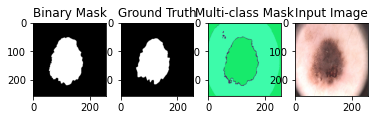

Evaluations:
DICE Score: 0.9334454150067615
HM Score: 0.12480296072921664
XOR Score: 0.1406720741599073 

-----------------Test 0 img_IMD004.bmp -----------------


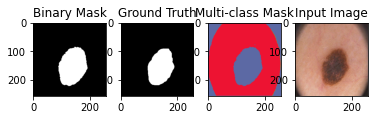

Evaluations:
DICE Score: 0.9239663449130233
HM Score: 0.14132207617768397
XOR Score: 0.16452585725455154 

-----------------Test 1 img_IMD021.bmp -----------------


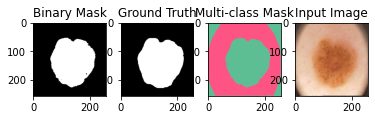

Evaluations:
DICE Score: 0.9613841287825143
HM Score: 0.074360256351984
XOR Score: 0.07510099155343371 

-----------------Test 2 img_IMD176.bmp -----------------


In [9]:
for img_num, (img_file, label_file) in enumerate(zip(img_data, lbl_data)):

    ######################################### Read Data #########################################
    im = cv2.imread(img_file)
    im = cv2.resize(im, (img_size, img_size))

    data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32')/255.]))
    data = data.to(device)
    
    lbl = cv2.imread(label_file, 0)
    lbl = cv2.resize(lbl, (img_size, img_size))
    lbl = np.where(lbl==0, lbl, 1)
    
    ######################################## Laod Model #########################################
    model = MSFormer(input_dim=3, embed_size=args.nChannel, img_size=img_size,
                  large_nlayers=large_nlayers, small_nlayers=small_nlayers).to(device)
    model.train()

    ######################################### Setteings #########################################
    # Cross-Entropy loss
    loss_ce = torch.nn.CrossEntropyLoss()
    # Intra-scale Loss
    loss_intra = torch.nn.L1Loss(reduction='mean')
    # Inter-scale Loss
    loss_inter = torch.nn.CosineEmbeddingLoss()


    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(100, 3))
    
    
    ######################################### Training #########################################
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        output, att_score, att_s, att_l = model(data)
        output = output[0]

        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
        
        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        nLabels = len(np.unique(img_target))
        
        # inter-scale loss (Corelation loss)
        inter_loss = 1.5 * loss_inter(att_s[0], att_l[0], torch.tensor([1]).cuda())
        # intra-scale loss (Attention Score loss)
        intra_loss = 1.3 * loss_intra(att_score[0], torch.eye(att_score.shape[2]).cuda())   
        # cross-entropy loss
        ce_loss = 1 * loss_ce(output, target)
        # Total loss
        loss =  ce_loss + inter_loss + intra_loss

        loss.backward()
        optimizer.step()

#         print (batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 8),
#                '| Inter(Cor):', round(inter_loss.item(), 8), '| Ce:', round(ce_loss.item(), 8), '| Intra:', round(intra_loss.item(), 8))
        if nLabels <= args.minLabels:
#             print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
            break

    ######################################### Evaluations #########################################
    output, _, _, _ = model(data)
    output = output[0]
    output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel)
    
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    
    # Create the binary mask #
    seg_mask = create_mask(img_target.reshape(img_size, img_size).astype(np.uint8), lbl)
    
    # Dice score metric
    dsc = dice_metric(seg_mask, lbl)
    
    # HM metric
    hm = hm_metric(seg_mask, lbl)
    
    # XOR metric
    xor = xor_metric(seg_mask, lbl)
        
    img_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in img_target])
    img_target_rgb = img_target_rgb.reshape(im.shape).astype(np.uint8)
    
    ######################################### Visualization #########################################
    f, axes = plt.subplots(1, 4, figsize=(6, 8))
    axes[0].imshow(seg_mask, 'gray')
    axes[1].imshow(lbl, 'gray')
    axes[2].imshow(img_target_rgb)
    axes[3].imshow(im[..., ::-1])
    axes[0].set_title('Binary Mask')
    axes[1].set_title('Ground Truth')
    axes[2].set_title('Multi-class Mask')
    axes[3].set_title('Input Image')
    plt.show()
    
    print('Evaluations:')
    print('DICE Score:', dsc)
    print('HM Score:', hm)
    print('XOR Score:', xor, '\n')
    
    if args.save_output:
        cv2.imwrite(SAVE_PATH + 'm_mask_' + os.path.basename(img_file).split('.')[0] + '.png', img_target_rgb)
        cv2.imwrite(SAVE_PATH + 'b_mask_' + os.path.basename(img_file).split('.')[0] + '.png', seg_mask * 255)
    
    print(f'-----------------Test {img_num} {os.path.basename(img_file)} -----------------')